# <center>COMPUTER VISION - ResNet152 MODEL</center>
***
## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES<br>
> B. CONSTANTS<br>
> C. COLLECTING DATA AND LOADING A SAMPLE<br>
> D. SPLIT BETWEEN TRAINING SET AND TEST SET<br>
> E. PREPARATION OF DATA WITH PREPROCESSING<br>

## <font color = blue>II. CALL BACKS</font>
> A. AUTOMATIC REDUCTION OF THE LEARNING RATE<br>
> B. EARLY STOPPING<br>

## <font color = blue>III. TRANSFER LEARNING</font>
> A. LOADING OF ResNet152 PRE-TRAINED MODEL<br>
> B. MODEL CREATION WITH LAST LAYERS<br>
> C. COMPILING AND TRAINING<br>
> D. TRAINING HISTORY<br>
> E. CONFUSION MATRIX<br>
> F. CLASSIFICATION REPORT<br>

## <font color = blue>IV. FINE TUNING</font>
> A. UNFREEZING WEIGHTS OF TOP LAYERS OF ResNet152<br>
> B. COMPILING AND TRAINING<br>
> C. TRAINING HISTORY<br>
> D. CONFUSION MATRIX<br>
> E. CLASSIFICATION REPORT<br>

## <font color = blue>V. WRONG PREDICTIONS</font>
***
##### Additional information before to get started :
* Recommended resolution for the pre-trained ResNet model : (224, 224, 3).
    * https://keras.io/api/applications/resnet/
* resnet.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

##### Laptop specification :
* OS: Windows 11
* Processor: AMD Ryzen 7 5800HS with Radeon Graphics 3.20 GHz
* Installed RAM: 16,0 GB
* GPU: NVIDIA GetForce RTX3080 8GB
***

## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from time import time

from helpers import load_image
from helpers import show_wrong_predictions

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import itertools

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import layers

> B. CONSTANTS

In [26]:
BATCH_SIZE       = 16                # Bacth size for dataset
TARGET_SIZE      = (224, 224)        # Resolution of images before training
INPUT_SHAPE      = (224, 224, 3)     # Resolution of images with channels before training
IMAGES_DIRECTORY = '../data/final/'  # Directory where are located images

SAVED_WEIGHTS    = './model/model_ResNet152.h5'  # File name where are saved the final weights of the model

> C. COLLECTING DATA AND LOADING A SAMPLE

In [3]:
df = pd.read_csv('../data/data_with_meta.csv')
df.head()

Unnamed: 0         filename  \
0           0  img_0000000.jpg   
1           1  img_0000001.jpg   
2           2  img_0000002.jpg   
3           3  img_0000003.jpg   
4           4  img_0000004.jpg   

                                                 url  \
0  https://templates.invoicehome.com/modele-factu...   
1  https://templates.invoicehome.com/modele-factu...   
2  https://www.coover.fr/wp-content/uploads/2021/...   
3  https://templates.invoicehome.com/modele-factu...   
4  https://files.intum.com/v/vosfactures/files/31...   

                                         description     type  \
0  100 modèles gratuits de factures | Téléchargem...  facture   
1  100 modèles gratuits de factures | Téléchargem...  facture   
2  Facture proforma : modèle à télécharger gratui...  facture   
3  100 modèles gratuits de factures | Téléchargem...  facture   
4  Base de Connaissances - Vos Factures - Créer u...  facture   

                  filepath  scraped     old_filename  \
0  ./final/img_0000000.jpg        1  img_0000000.jpg   
1  ./final/img_0000001.jpg        1  img_0000001.jpg   
2  ./final/img_0000002.jpg        1  img_0000002.jpg   
3  ./final/img_0000003.jpg        1  img_0000003.jpg   
4  ./final/img_0000004.jpg        1  img_0000004.jpg   

                old_filepath  height  width  channels  landscape  
0  ./facture/img_0000000.jpg  1061.0  750.0       3.0        0.0  
1  ./facture/img_0000001.jpg  1061.0  750.0       3.0        0.0  
2  ./facture/img_0000002.jpg  1024.0  726.0       3.0        0.0  
3  ./facture/img_0000003.jpg  1061.0  750.0       3.0        0.0  
4  ./facture/img_0000004.jpg   771.0  773.0       3.0        1.0

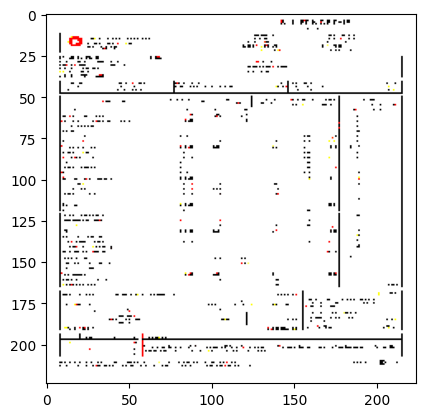

In [4]:
# Display a document randomly
num_alea = np.random.randint(len(df))

plt.imshow(load_image(directory = IMAGES_DIRECTORY,
                      filename = df.filename[num_alea],
                      preprocess = preprocess_input));

#Comments:
#- The method load_image is resizing images to (224, 224) by default,

> D. SPLIT BETWEEN TRAINING SET AND TEST SET

In [5]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df.filename, df.type,
                                                              test_size = 0.2, random_state = 1234)

data_train ={'filename': X_train_path, 'type': y_train.astype('category')}
df_train = pd.DataFrame(data_train)

data_test ={'filename': X_test_path, 'type': y_test.astype('category')}
df_test = pd.DataFrame(data_test)

> E. PREPARATION OF DATA WITH PREPROCESSING

In [6]:
# Images generator for training set
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)      # data preprocessing


# Generator for test set (we don't increase the test set)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train,          # Dataframe
                                                           directory = IMAGES_DIRECTORY,  # Directory with pics
                                                           class_mode = 'categorical',    # Multiple classes
                                                           target_size = TARGET_SIZE,     # Resizing
                                                           x_col = 'filename',            # Column with filenames
                                                           y_col = 'type',                # Column with classes
                                                           batch_size = BATCH_SIZE)       # Batch size

test_generator = test_data_generator.flow_from_dataframe(dataframe = df_test,             # Dataframe
                                                         directory = IMAGES_DIRECTORY,    # Directory with pics
                                                         class_mode = 'categorical',      # Multiple classes
                                                         target_size = TARGET_SIZE,       # Resizing
                                                         x_col = 'filename',              # Column with filenames
                                                         y_col = 'type',                  # Column with classes
                                                         batch_size = BATCH_SIZE)         # Batch size

Found 1046 validated image filenames belonging to 22 classes.
Found 262 validated image filenames belonging to 22 classes.


## <font color = blue>II. CALL BACKS</font>
> A. AUTOMATIC REDUCTION OF THE LEARNING RATE

In [7]:
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',                # Metric to control
                                         patience = 3,                        # Number of epochs to wait before decreasing the learning rate
                                         factor = 0.1,
                                         verbose = 2,                         # Number of informations displayed during training
                                         mode = 'min')                        # Indicate the metric decrease

> B. EARLY STOPPING

In [8]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',          # Metric to control
                                         patience = 8,                  # Number of epochs to wait before stopping the training
                                         mode = 'min',                  # Indicate the metric decrease
                                         restore_best_weights = True)   # To restore the weights of the best epoch

## <font color = blue>III. TRANSFER LEARNING</font>
> A. LOADING OF ResNet152 PRE-TRAINED MODEL

In [9]:
# Loading
resnet = ResNet152(include_top = False, input_shape = INPUT_SHAPE)

# Freezing weigths
for layer in resnet.layers:
    layer.trainable = False

resnet.summary()

234698864/234698864 [==============================] - 4s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block6_2_relu[0][0]']    
          

                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block8_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block10_1_relu[0][0]']   
                                                                                                  
 conv4_block10_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block13_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block13_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block13_1_relu[0][0]']   
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block13_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block16_1_relu[0][0]']   
                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block16_2_conv[0][0]']   
 lization)

 conv4_block19_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block18_out[0][0]']      
                                                                                                  
 conv4_block19_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block22_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block21_out[0][0]']      
                                                                                                  
 conv4_block22_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block22_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block22_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block22_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block22_1_relu[0][0]']   
          

                                )                                                                 
                                                                                                  
 conv4_block25_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block24_out[0][0]']      
                                                                                                  
 conv4_block25_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block27_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block27_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block27_out[0][0]']      
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block30_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block30_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block30_out[0][0]']      
                                                                                                  
 conv4_block31_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block31_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block31_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block31_1_bn[0][0]']     
 on)      

                                )                                 'conv4_block33_3_bn[0][0]']     
                                                                                                  
 conv4_block33_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block33_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block34_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block33_out[0][0]']      
                                                                                                  
 conv4_block34_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block34_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block36_add (Add)        (None, 14, 14, 1024  0           ['conv4_block35_out[0][0]',      
                                )                                 'conv4_block36_3_bn[0][0]']     
                                                                                                  
 conv4_block36_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block36_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block36_out[0][0]']      
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block3_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
Total params: 58,370,944
Trainable params: 0
Non-trainable params: 58,370,944
__________________________________________________________________________________________________


> B. MODEL CREATION WITH LAST LAYERS

In [10]:
model = Sequential()
model.add(resnet)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 22, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

> C. COMPILING AND TRAINING

In [11]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),              # loss function
              optimizer = tf.keras.optimizers.Adam(),                        # optimizer algorithm
              metrics = ['accuracy'])                                        # metric

In [12]:
# Initialization of a timer
t0 = time()

history = model.fit(x = train_generator,                                     # Training data
                    validation_data = test_generator,                        # Validation data
                    epochs = 50,                                             # Number of epoch
                    steps_per_epoch = (len(X_train_path)) // BATCH_SIZE,     # Number of steps per Epoch
                    validation_steps = (len(X_test_path)) // BATCH_SIZE,     # Number of iterations during the test  
                    callbacks = [lr_plateau, early_stopping],                # Callbacks
                    workers = -1)                                            # Using all processors

# Calulation of training time
t1 = time() - t0
print("Training time in {} minutes".format(t1 // 60))

Epoch 1/50


C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 [==============================] - 27s 377ms/step - loss: 2.0325 - accuracy: 0.4369 - val_loss: 1.6103 - val_accuracy: 0.4961 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 24s 364ms/step - loss: 1.1470 - accuracy: 0.6437 - val_loss: 1.3226 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 24s 367ms/step - loss: 0.9210 - accuracy: 0.7126 - val_loss: 1.4758 - val_accuracy: 0.6016 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - 24s 363ms/step - loss: 0.8850 - accuracy: 0.7175 - val_loss: 1.3492 - val_accuracy: 0.6133 - lr: 0.0010
Epoch 5/50
65/65 [==============================] - ETA: 0s - loss: 0.7298 - accuracy: 0.7650
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
65/65 [==============================] - 24s 368ms/step - loss: 0.7298 - accuracy: 0.7650 - val_loss: 1.3778 - val_accuracy: 0.5977 - lr: 0.0010
Epoch 6/50
65/65 [==============================] - 24s 369ms/step - lo

> D. TRAINING HISTORY

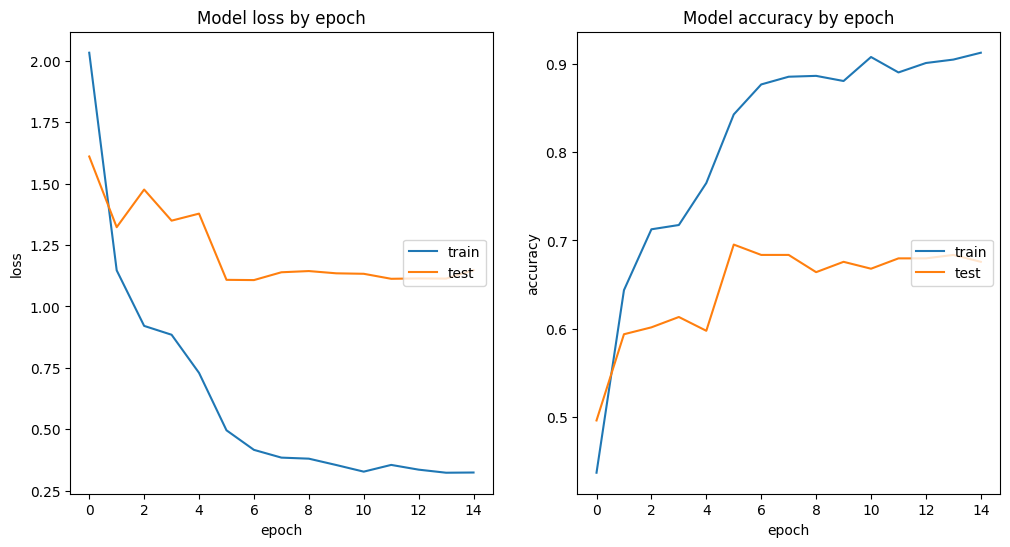

In [13]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

> E. CONFUSION MATRIX

In [14]:
# Probability predictions
X_test = [load_image(directory = IMAGES_DIRECTORY, filename = x, preprocess = preprocess_input) for x in X_test_path]
y_prob = [model.predict(np.array([x], dtype = np.float32))[0] for x in X_test]

# Class predictions
y_pred = tf.argmax(y_prob, axis = -1).numpy()

1/1 [==============================] - 0s 112ms/step


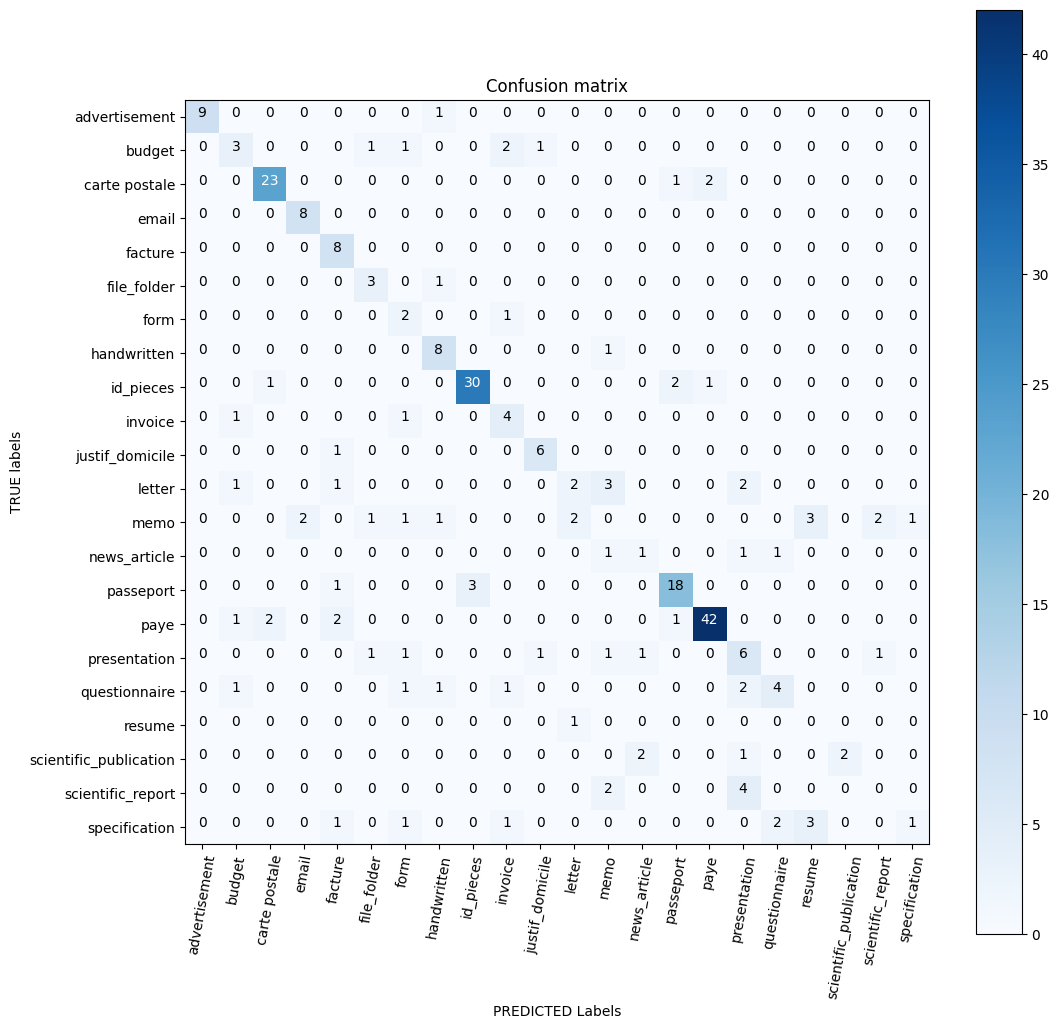

In [15]:
# Dictionaries for target
dico_type = test_generator.class_indices
dico_type_inv = {v: k for k, v in dico_type.items()}

# Class predictions with type (passport, resume, etc...)
y_pred_type = pd.DataFrame(y_pred, index = y_test.index).replace(dico_type_inv)

cnf_matrix = confusion_matrix(y_test, y_pred_type)

classes = dico_type

plt.figure(figsize = (12, 12))

plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 80)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('TRUE labels')
plt.xlabel('PREDICTED Labels')
plt.show()

> F. CLASSIFICATION REPORT

In [16]:
print( classification_report(y_test, y_pred_type) )

                        precision    recall  f1-score   support

         advertisement       1.00      0.90      0.95        10
                budget       0.43      0.38      0.40         8
         carte postale       0.88      0.88      0.88        26
                 email       0.80      1.00      0.89         8
               facture       0.57      1.00      0.73         8
           file_folder       0.50      0.75      0.60         4
                  form       0.25      0.67      0.36         3
           handwritten       0.67      0.89      0.76         9
             id_pieces       0.91      0.88      0.90        34
               invoice       0.44      0.67      0.53         6
       justif_domicile       0.75      0.86      0.80         7
                letter       0.40      0.22      0.29         9
                  memo       0.00      0.00      0.00        13
          news_article       0.25      0.25      0.25         4
             passeport       0.82      

## <font color = blue>IV. FINE TUNING</font>
> A. UNFREEZING WEIGHTS OF TOP LAYERS OF ResNet152

<font color = red>We unfreeze the top 20 layers while leaving BatchNorm layers frozen.</font>

In [17]:
for layer in resnet.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

> B. COMPILING AND TRAINING

In [18]:
last_learning_rate = model.optimizer.learning_rate.numpy()              # collect last learning rate from previous training

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),                            # loss function
              optimizer = tf.keras.optimizers.Adam(learning_rate = last_learning_rate),    # optimizer algorithm
              metrics = ['accuracy'])                                                      # metric

In [19]:
# Initialization of a timer
t0 = time()

history = model.fit(x = train_generator,                                     # Training data
                    validation_data = test_generator,                        # Validation data
                    epochs = 50,                                             # Number of epoch
                    steps_per_epoch = (len(X_train_path)) // BATCH_SIZE,     # Number of steps per Epoch
                    validation_steps = (len(X_test_path)) // BATCH_SIZE,     # Number of iterations during the test  
                    callbacks = [lr_plateau, early_stopping],                # Callbacks
                    workers = -1)                                            # Using all processors

# Calulation of training time
t1 = time() - t0
print("Training time in {} minutes".format(t1 // 60))

Epoch 1/50


C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 [==============================] - 25s 377ms/step - loss: 0.3879 - accuracy: 0.8883 - val_loss: 1.1396 - val_accuracy: 0.6914 - lr: 1.0000e-06
Epoch 2/50
65/65 [==============================] - 24s 369ms/step - loss: 0.3684 - accuracy: 0.8864 - val_loss: 1.1251 - val_accuracy: 0.6953 - lr: 1.0000e-06
Epoch 3/50
65/65 [==============================] - 24s 363ms/step - loss: 0.3778 - accuracy: 0.8816 - val_loss: 1.1301 - val_accuracy: 0.6914 - lr: 1.0000e-06
Epoch 4/50
65/65 [==============================] - 24s 364ms/step - loss: 0.3685 - accuracy: 0.8903 - val_loss: 1.1387 - val_accuracy: 0.6836 - lr: 1.0000e-06
Epoch 5/50
65/65 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8757
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
65/65 [==============================] - 23s 362ms/step - loss: 0.3796 - accuracy: 0.8757 - val_loss: 1.1306 - val_accuracy: 0.6836 - lr: 1.0000e-06
Epoch 6/50
65/65 [==============================] -

In [27]:
####### SAVING WEIGHTS #######
model.save_weights(SAVED_WEIGHTS)

> C. TRAINING HISTORY

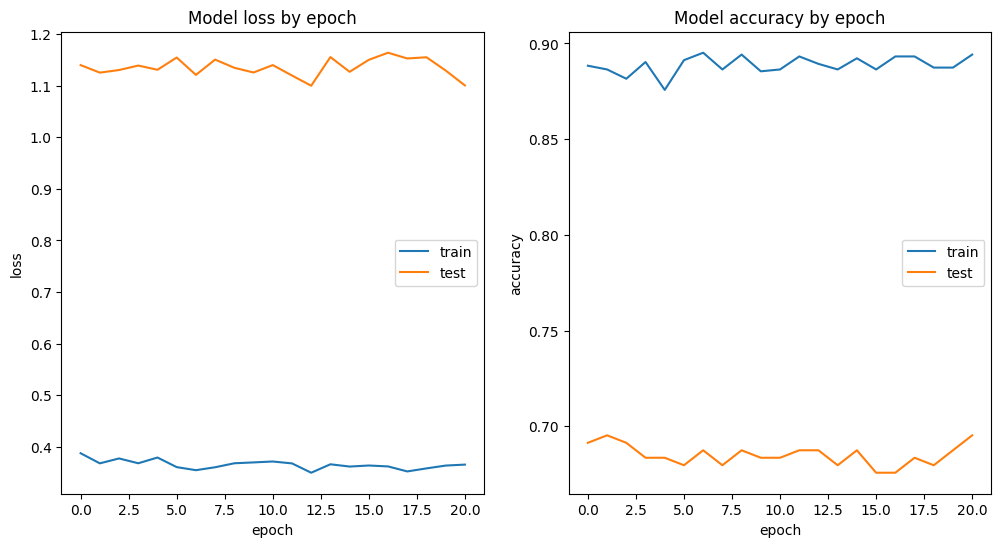

In [21]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

> D. CONFUSION MATRIX

In [22]:
# Probability predictions
X_test = [load_image(directory = IMAGES_DIRECTORY, filename = x, preprocess = preprocess_input) for x in X_test_path]
y_prob = [model.predict(np.array([x], dtype = np.float32))[0] for x in X_test]

# Class predictions
y_pred = tf.argmax(y_prob, axis = -1).numpy()

1/1 [==============================] - 0s 127ms/step


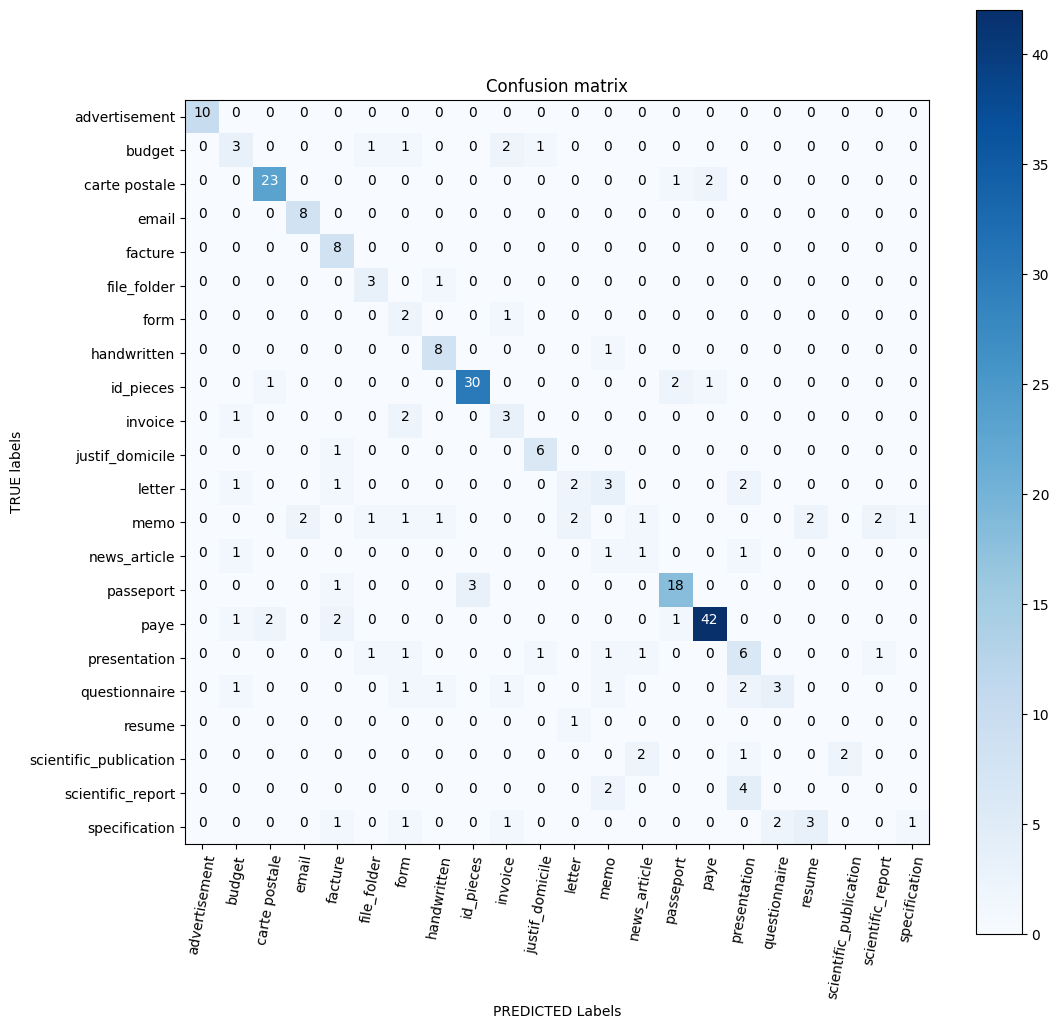

In [23]:
# Class predictions with type (passport, resume, etc...)
y_pred_type = pd.DataFrame(y_pred, index = y_test.index).replace(dico_type_inv)

cnf_matrix = confusion_matrix(y_test, y_pred_type)

classes = dico_type

plt.figure(figsize = (12, 12))

plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 80)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('TRUE labels')
plt.xlabel('PREDICTED Labels')
plt.show()

> E. CLASSIFICATION REPORT

In [24]:
print( classification_report(y_test, y_pred_type) )

                        precision    recall  f1-score   support

         advertisement       1.00      1.00      1.00        10
                budget       0.38      0.38      0.38         8
         carte postale       0.88      0.88      0.88        26
                 email       0.80      1.00      0.89         8
               facture       0.57      1.00      0.73         8
           file_folder       0.50      0.75      0.60         4
                  form       0.22      0.67      0.33         3
           handwritten       0.73      0.89      0.80         9
             id_pieces       0.91      0.88      0.90        34
               invoice       0.38      0.50      0.43         6
       justif_domicile       0.75      0.86      0.80         7
                letter       0.40      0.22      0.29         9
                  memo       0.00      0.00      0.00        13
          news_article       0.20      0.25      0.22         4
             passeport       0.82      

## <font color = blue>V. WRONG PREDICTIONS</font>

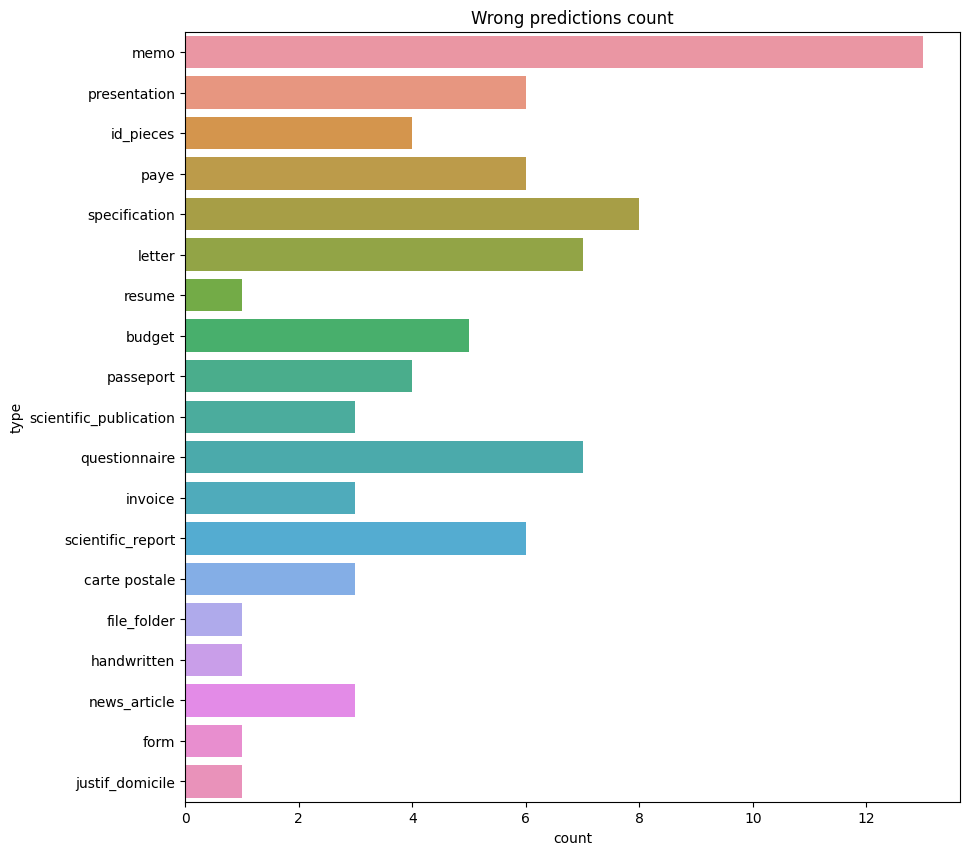

## Wrong predictions for memo

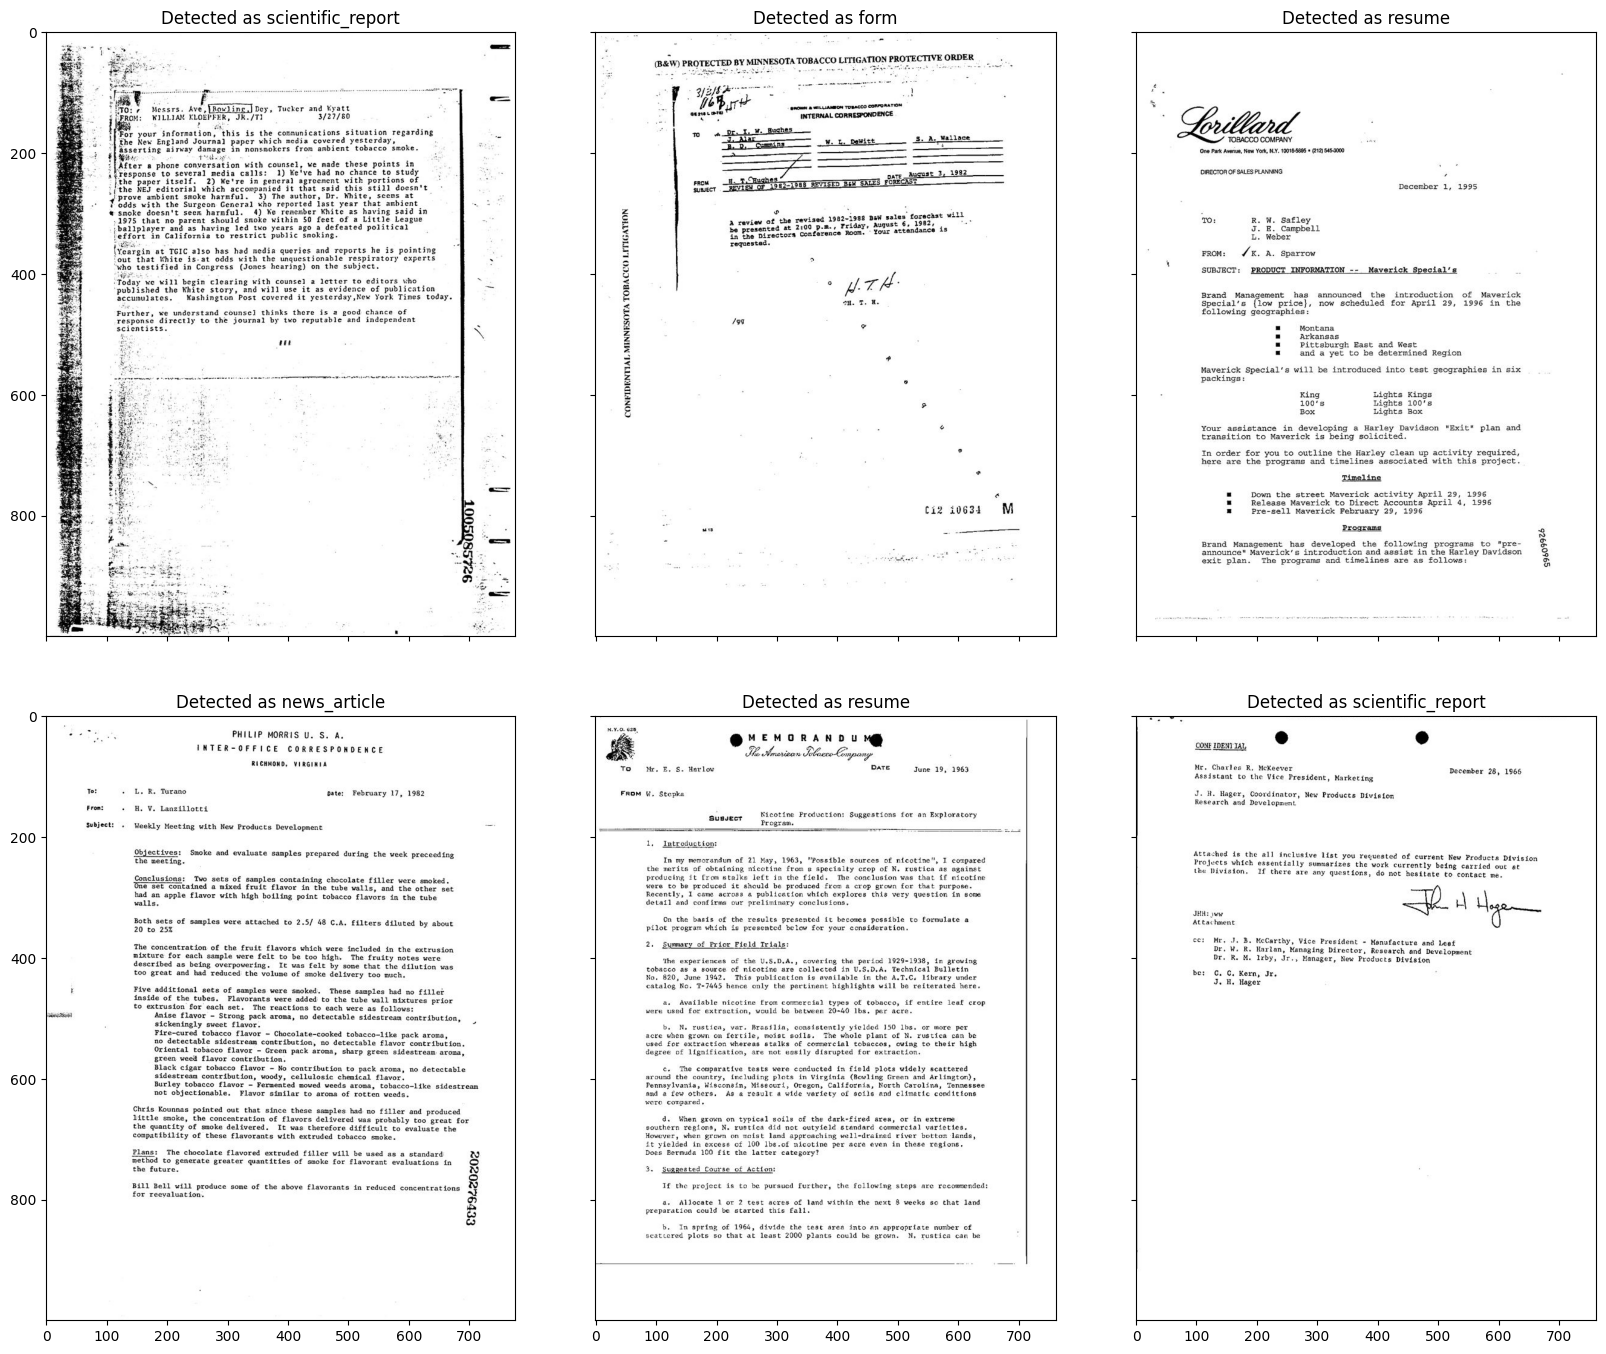

## Wrong predictions for specification

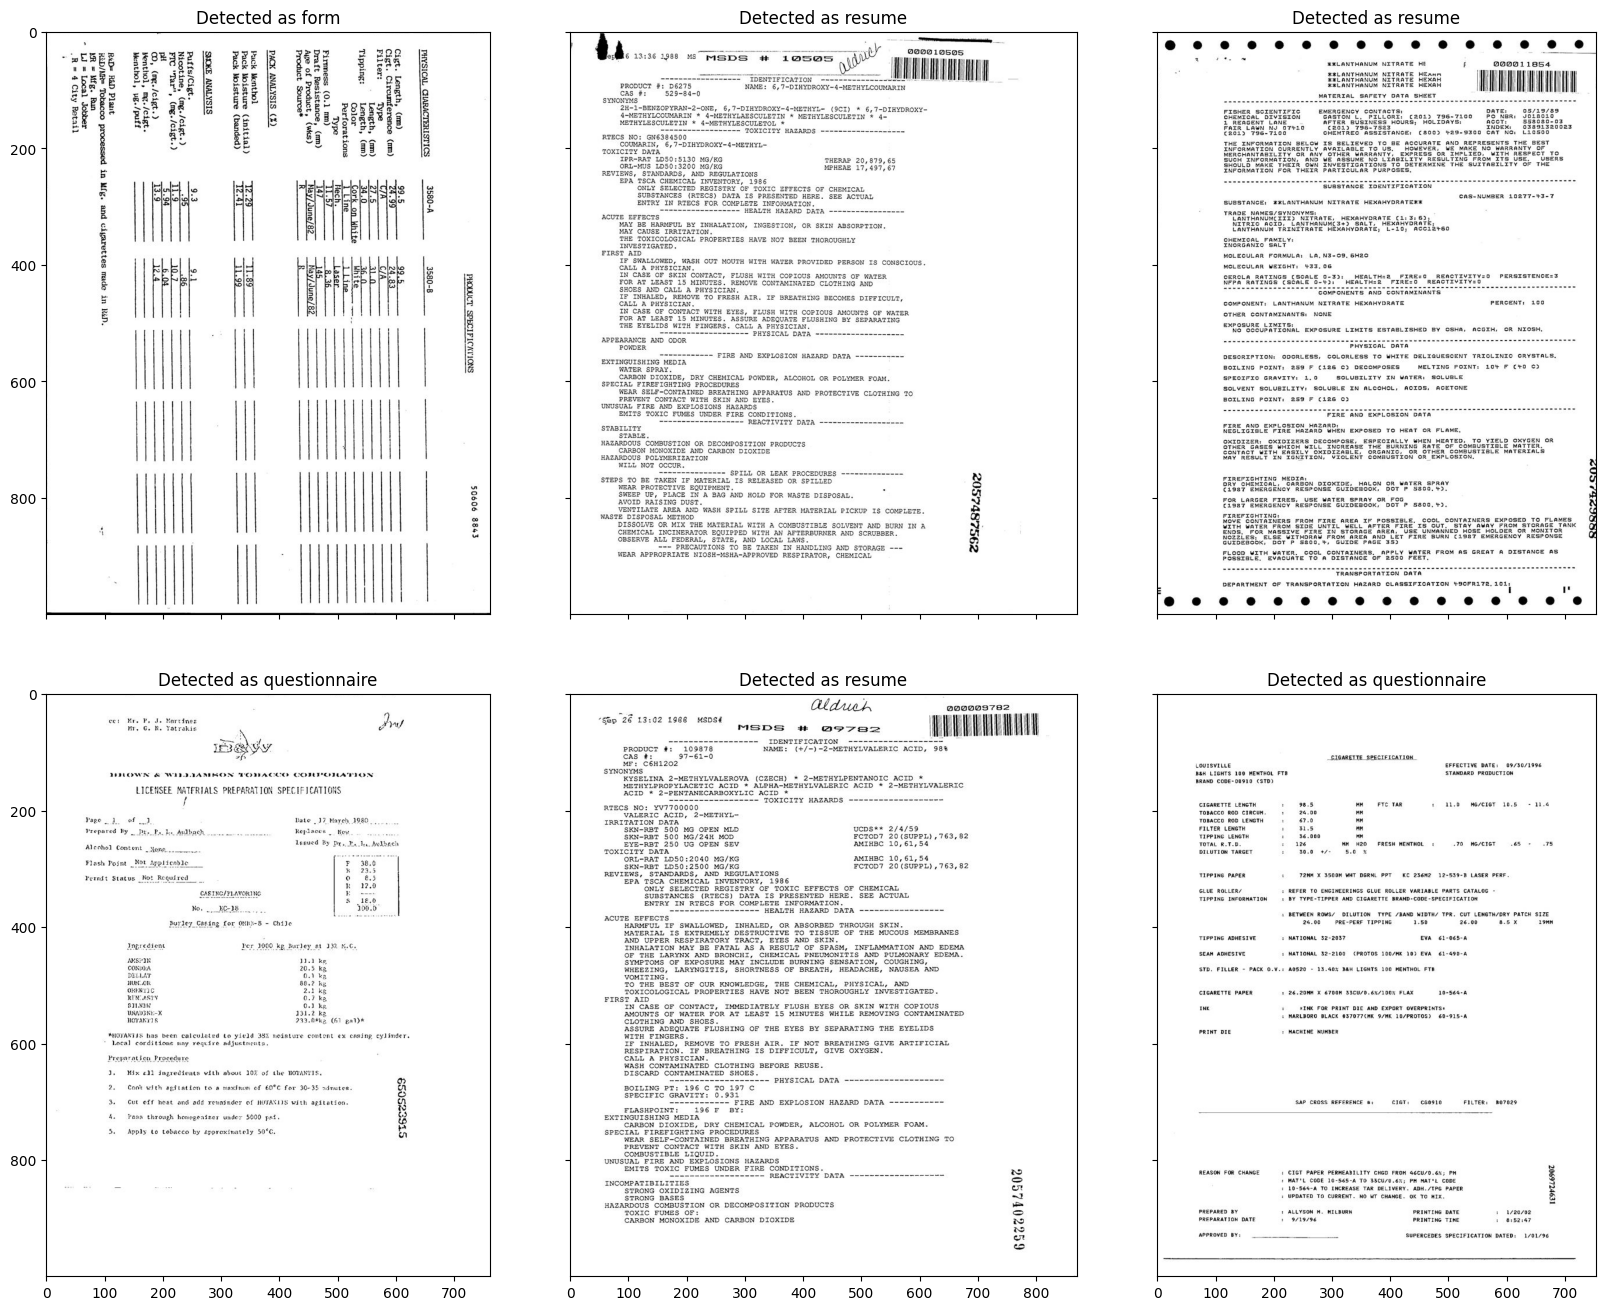

## Wrong predictions for letter

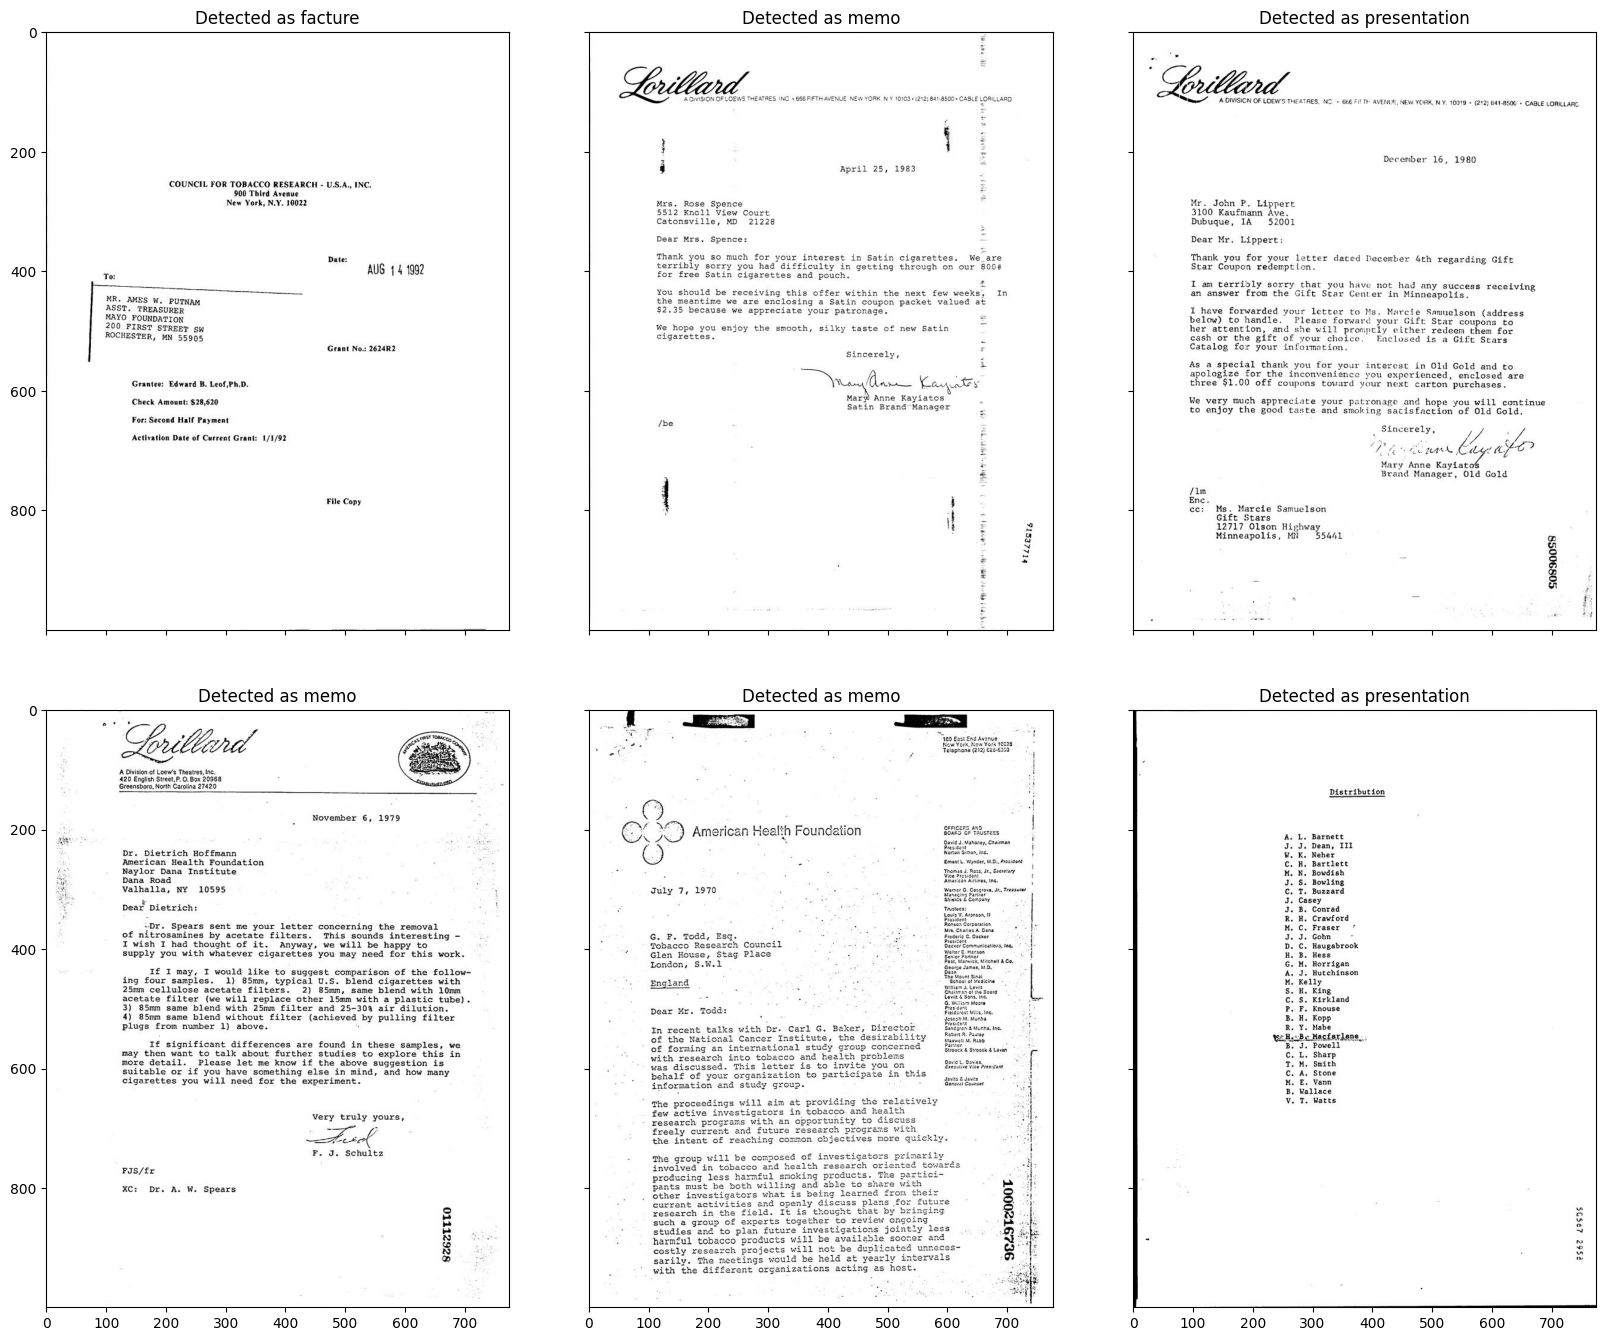

## Wrong predictions for questionnaire

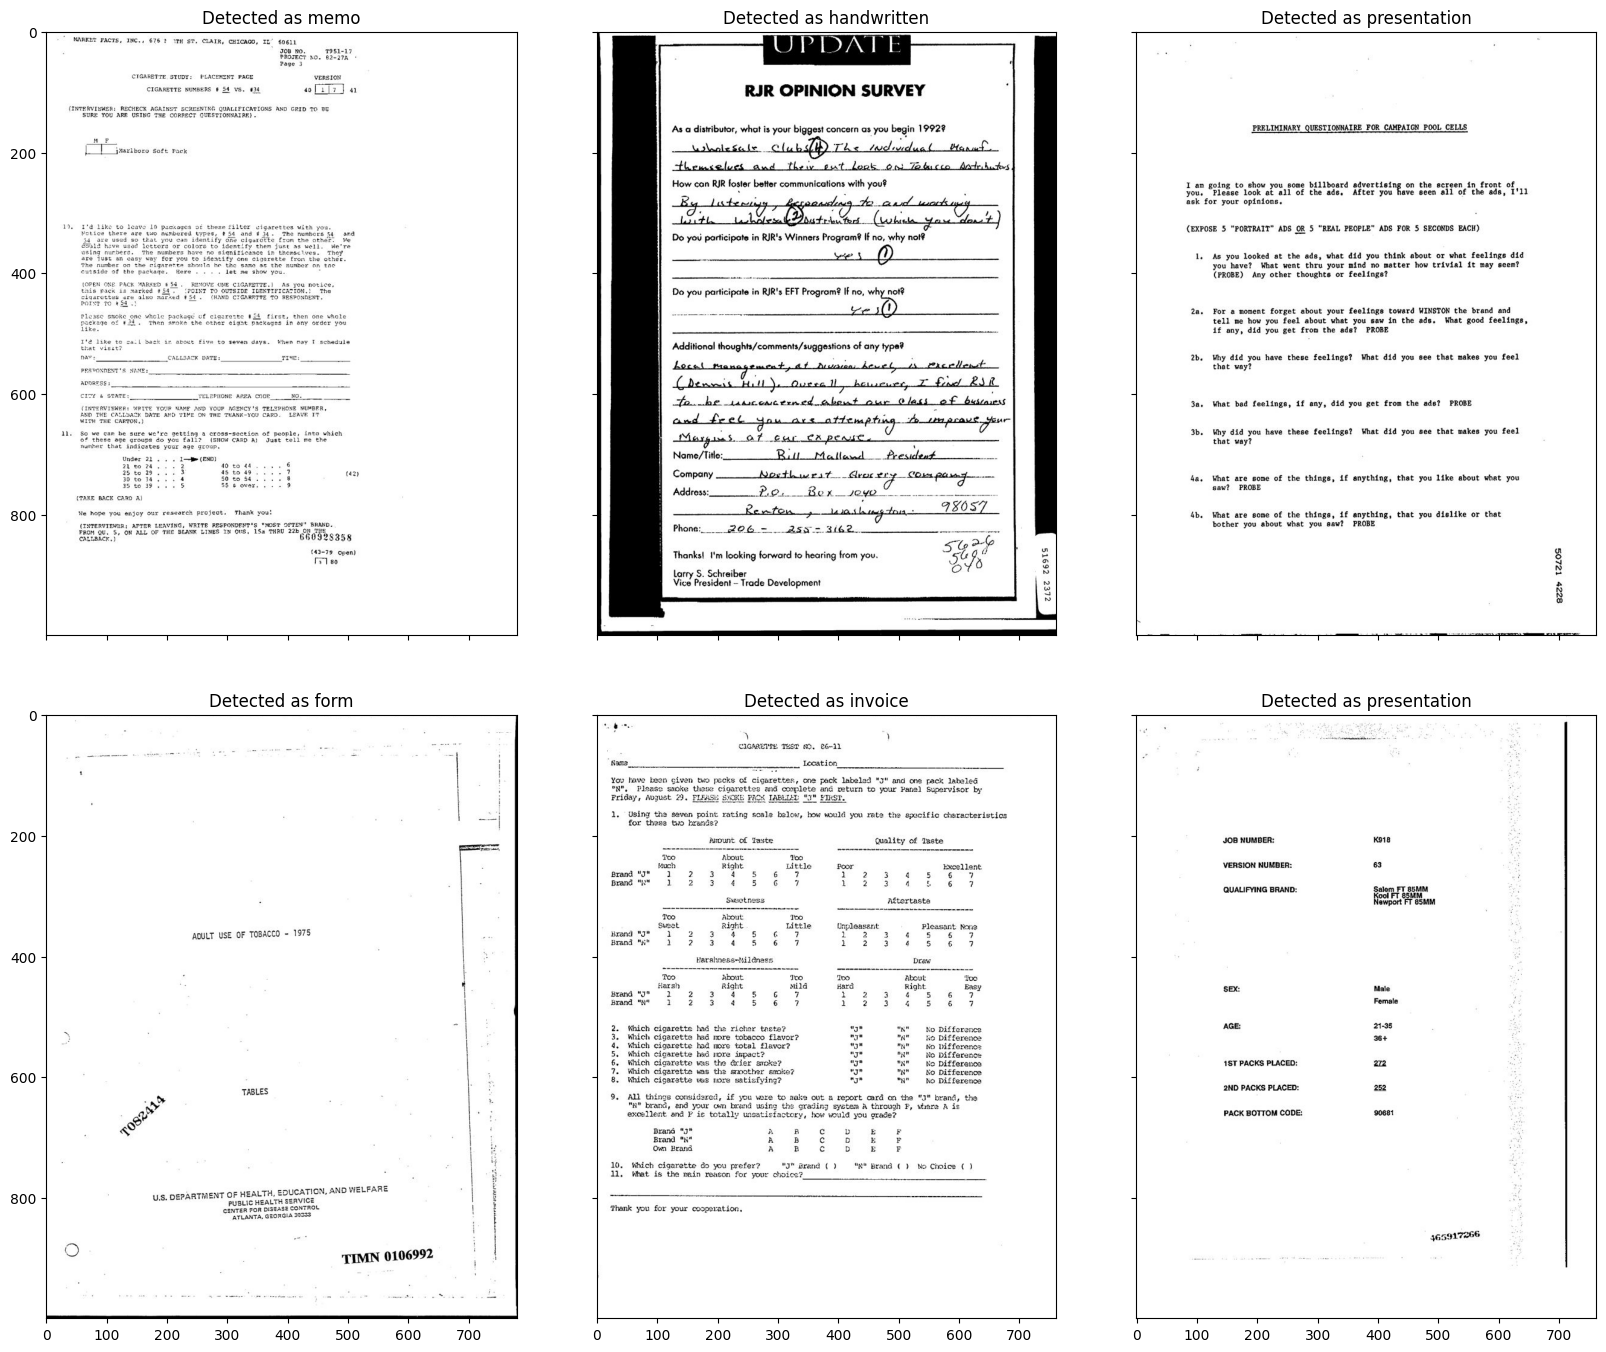

## Wrong predictions for scientific_report

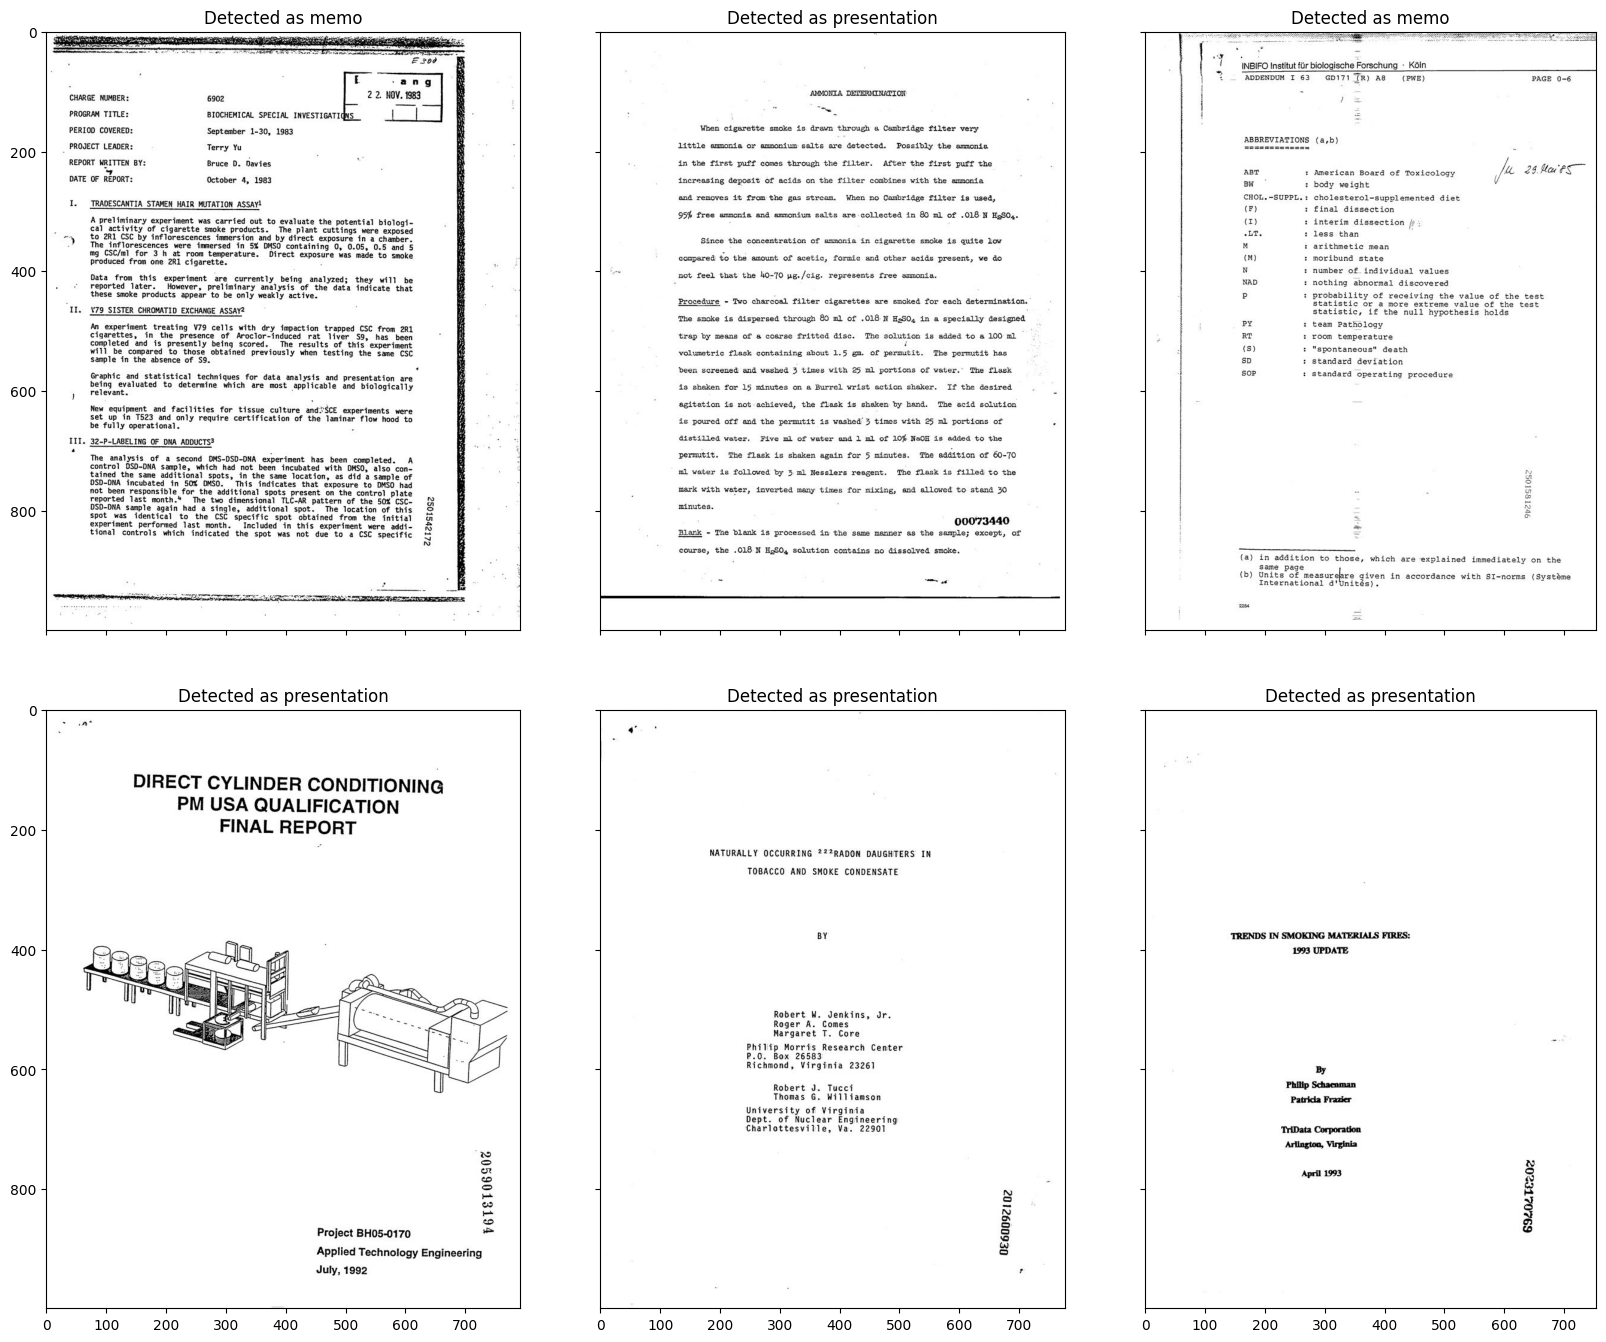

## Wrong predictions for paye

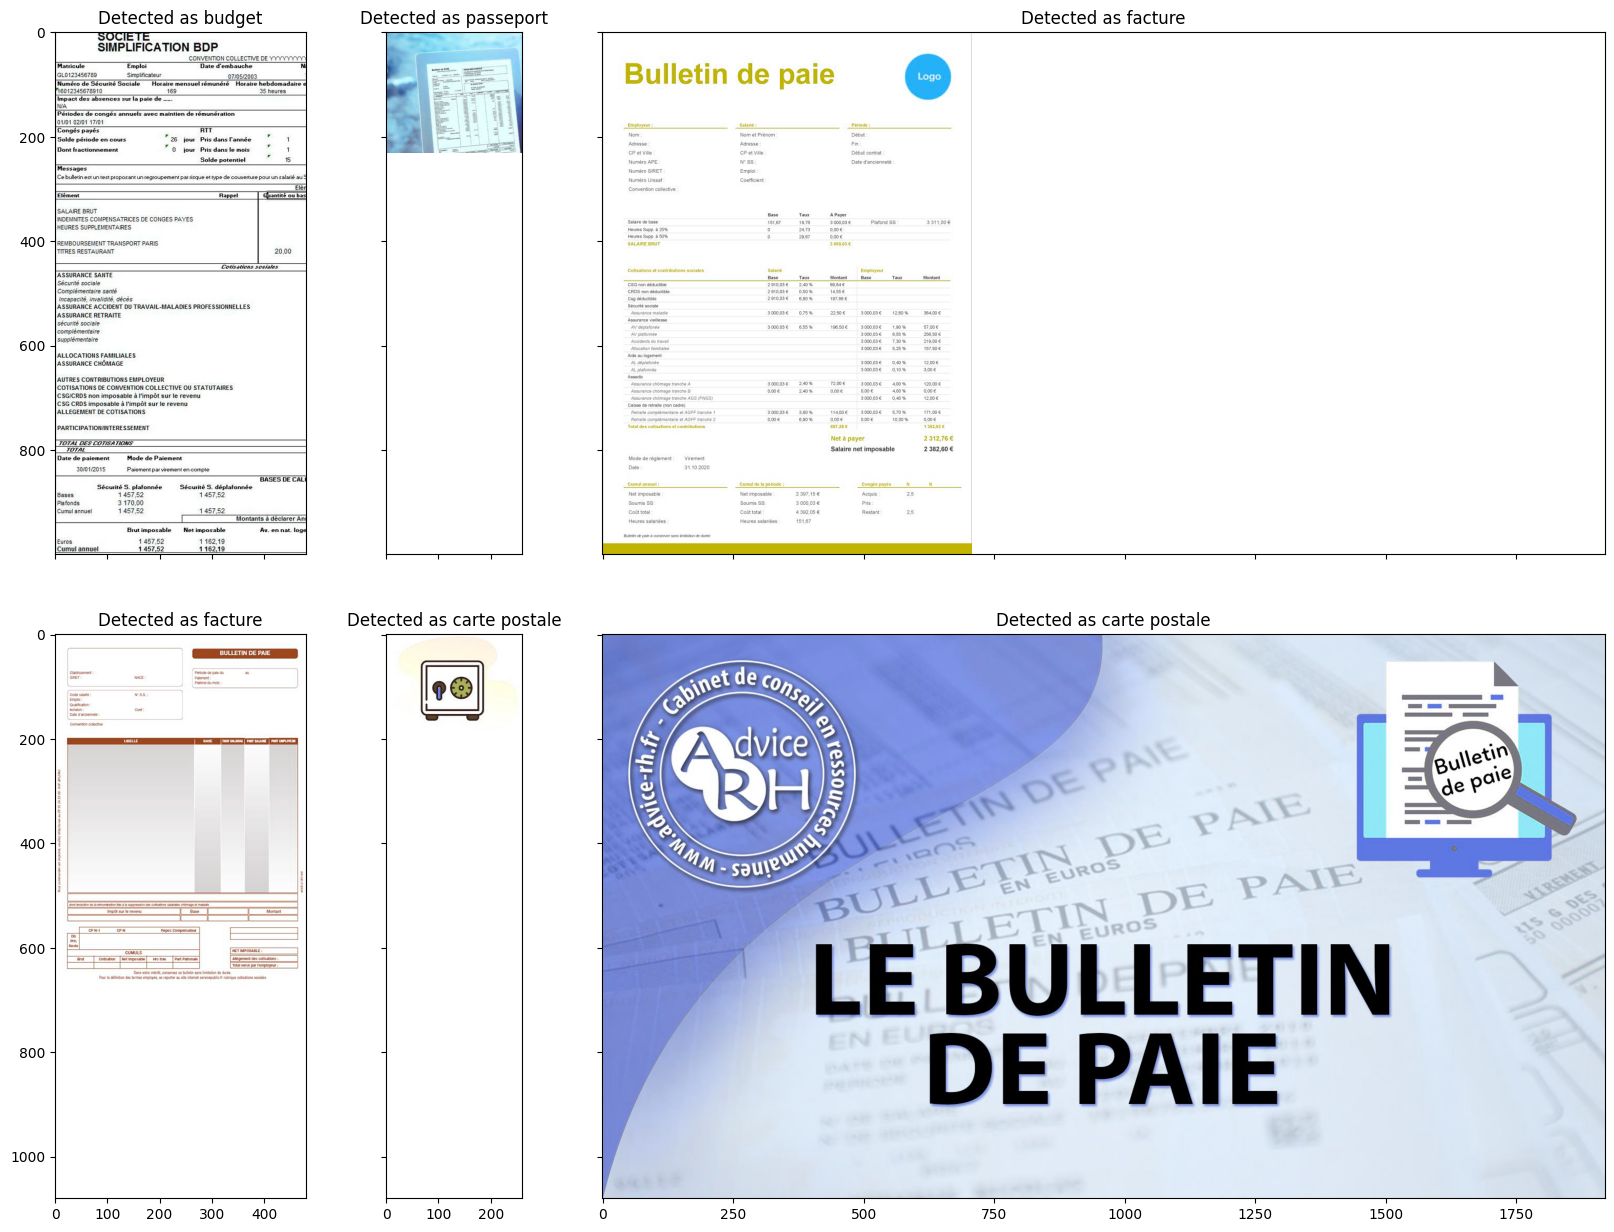

## Wrong predictions for presentation

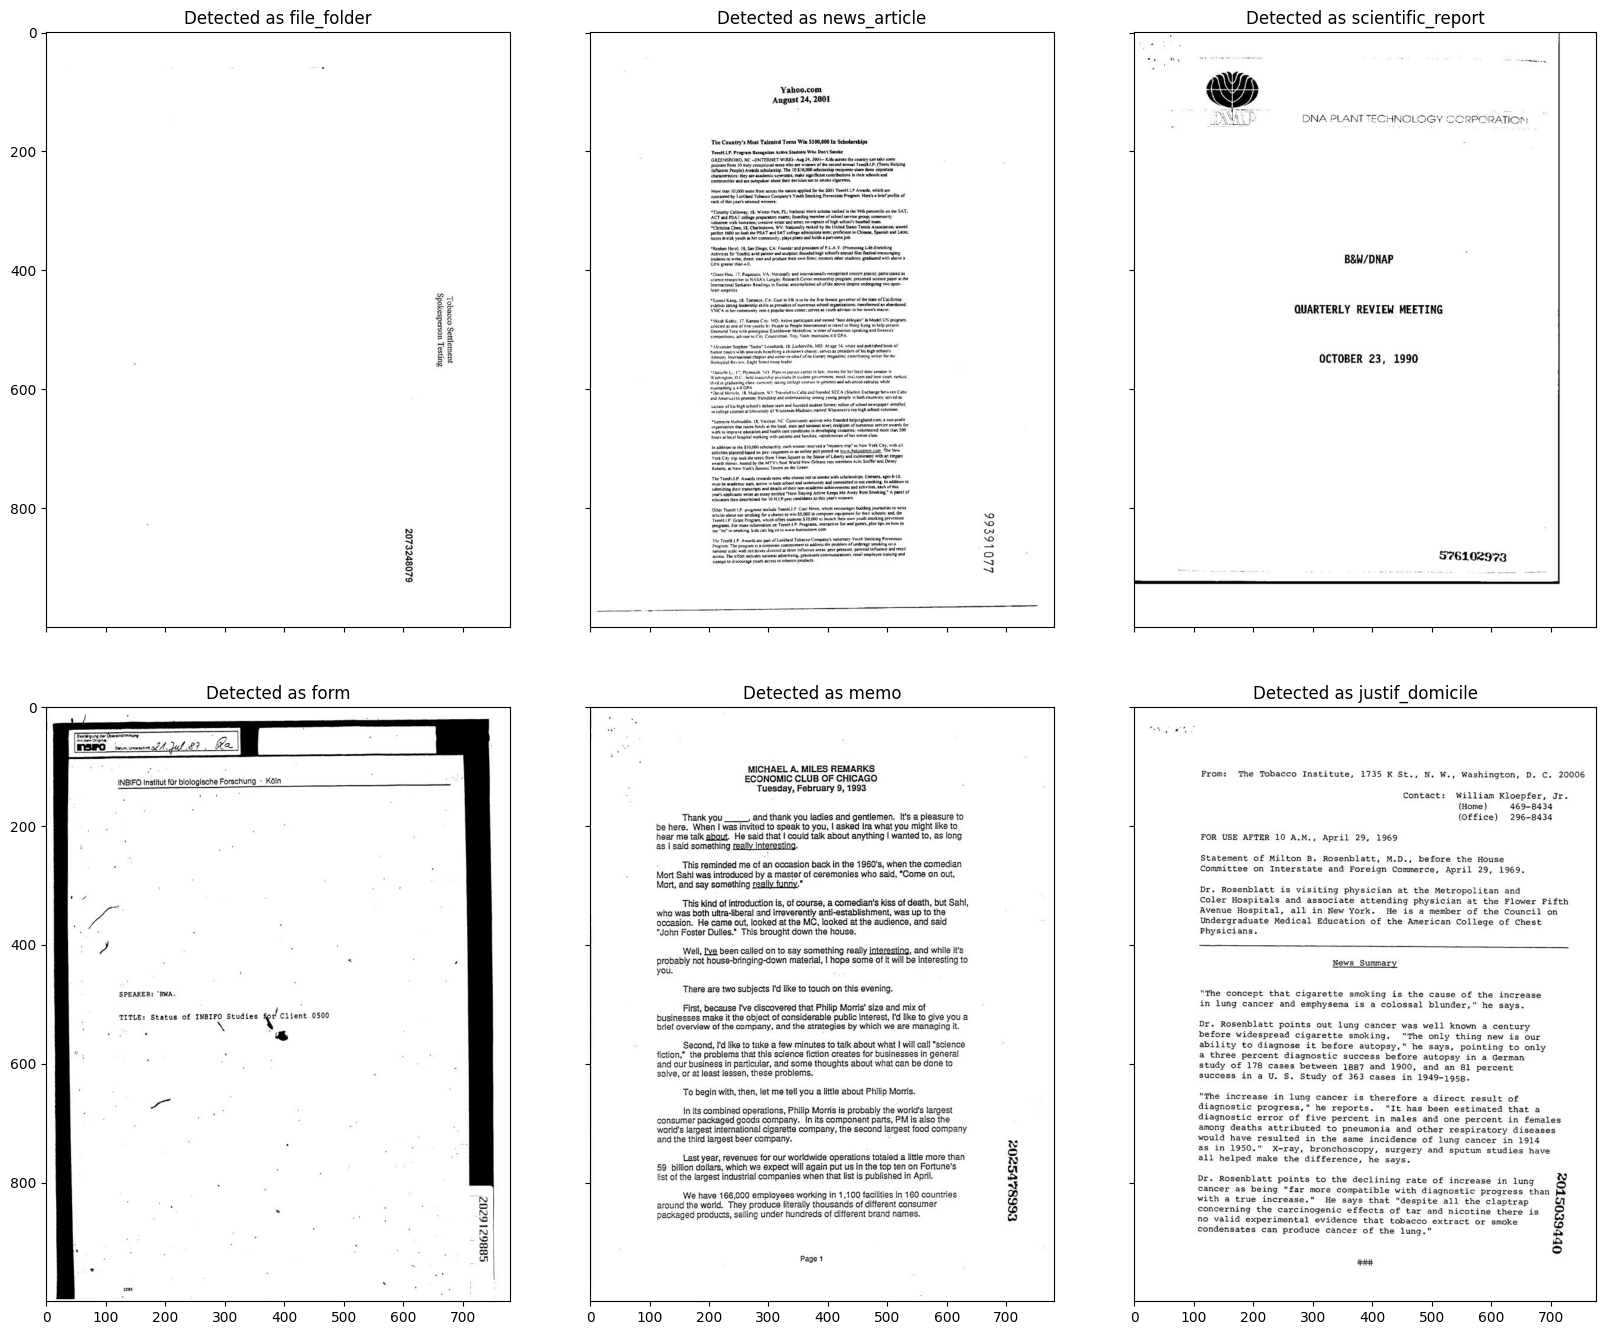

## Wrong predictions for budget

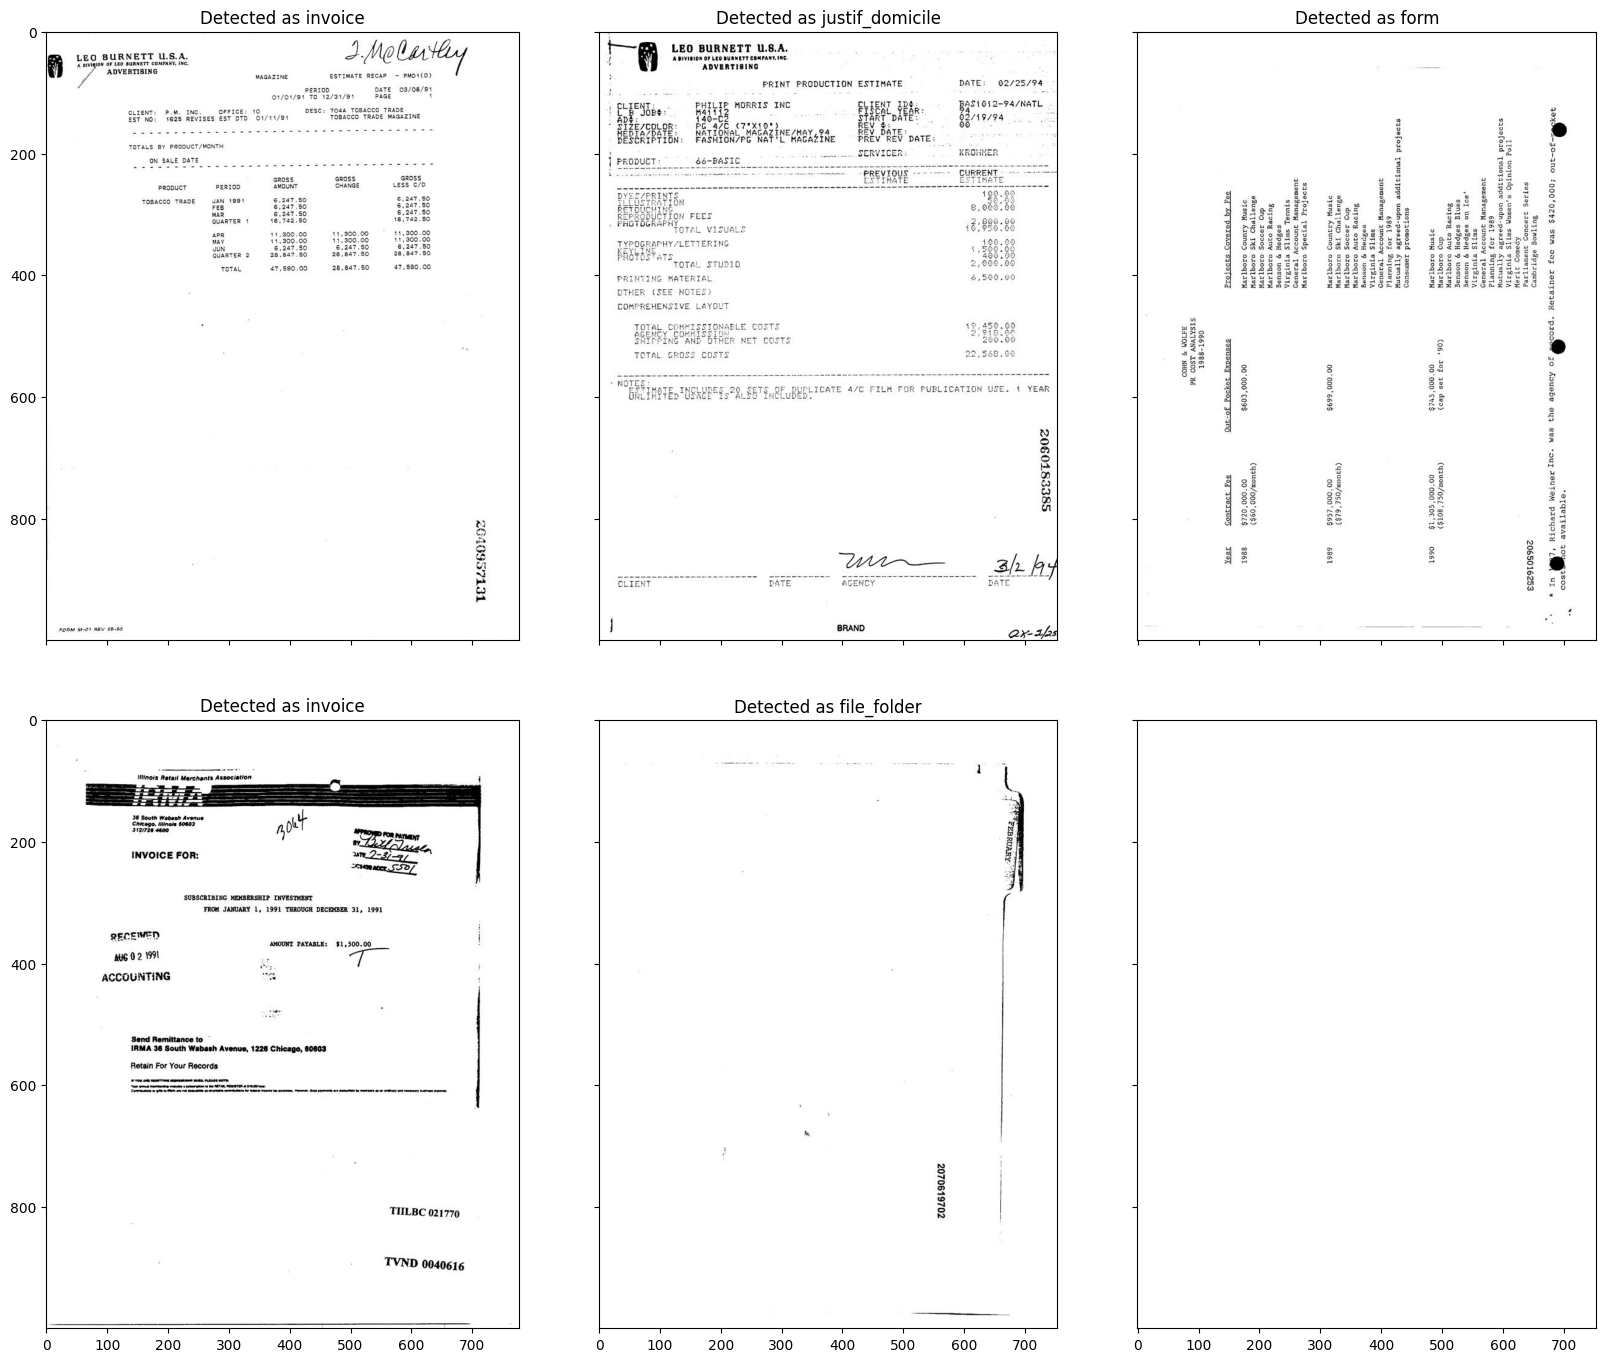

In [25]:
show_wrong_predictions(df, y_test, y_pred_type)